# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\karth\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

In [ ]:
display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [ ]:
preprocessed_reviews[1500]

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [ ]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.0] Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, f1_score, fbeta_score, roc_auc_score,roc_curve, recall_score
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import SGDClassifier
import pickle as pickle
import sqlite3

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

### splitting positive and negative reviews 

In [ ]:
con = sqlite3.connect('final.sqlite')

In [ ]:
df = pd.read_sql_query('''
SELECT * FROM Reviews
WHERE SCORE !=3
''', con)

In [ ]:
df.Score.replace(to_replace=[1,2], value=0, inplace=True)

In [ ]:
df.Score.replace(to_replace=[5,4], value=1, inplace=True)

In [ ]:
df.Score.value_counts()

In [ ]:
positivereviews = df[df['Score'] == 1]

In [ ]:
negativereviews = df[df['Score'] == 0]

In [ ]:
postext = positivereviews.CleanedText

In [ ]:
negtext = negativereviews.CleanedText

In [ ]:
pos_y = positivereviews.Score

In [ ]:
pos_y.shape

In [ ]:
pos_n = negativereviews.Score

### Importing time sorted splitted data

In [ ]:
pickle_in = open('train60k.pkl', 'rb')
x_train = pickle.load(pickle_in)

In [ ]:
pickle_in = open('test20k.pkl', 'rb')
x_test = pickle.load(pickle_in)

In [ ]:
pickle_in = open('cv20k.pkl', 'rb')
x_cv = pickle.load(pickle_in)

In [ ]:
pickle_in = open('ytrain.pkl', 'rb')
y_train = pickle.load(pickle_in)

In [ ]:
pickle_in = open('ytest.pkl', 'rb')
y_test = pickle.load(pickle_in)

In [ ]:
pickle_in = open('ycv.pkl', 'rb')
y_cv = pickle.load(pickle_in)

In [ ]:
pickle_in = open('train_tfidf.pkl', 'rb')
train_tfidf = pickle.load(pickle_in)

In [ ]:
pickle_in = open('test_tfidf.pkl', 'rb')
test_tfidf = pickle.load(pickle_in)

In [ ]:
pickle_in = open('cv_tfidf.pkl', 'rb')
cv_tfidf = pickle.load(pickle_in)

In [ ]:
pickle_in = open('avgw2v_train.pkl', 'rb')
avgw2v_train = pickle.load(pickle_in)

In [ ]:
pickle_in = open('avgw2v_test.pkl', 'rb')
avgw2v_test = pickle.load(pickle_in)

In [ ]:
pickle_in = open('avgw2v_cv.pkl', 'rb')
avgw2v_cv = pickle.load(pickle_in)

In [ ]:
pickle_in = open('tfidfw2v_train.pkl', 'rb')
tfidfw2v_train = pickle.load(pickle_in)

In [ ]:
pickle_in = open('tfidfw2v_test.pkl', 'rb')
tfidfw2v_test = pickle.load(pickle_in)

In [ ]:
pickle_in = open('tfidfw2v_cv.pkl', 'rb')
tfidfw2v_cv = pickle.load(pickle_in)

In [ ]:
pickle_in = open('train_bow_count.pkl', 'rb')
train_bow_count = pickle.load(pickle_in)

In [ ]:
pickle_in = open('test_bow_count.pkl', 'rb')
test_bow_count = pickle.load(pickle_in)

In [ ]:
pickle_in = open('cv_bow_count.pkl', 'rb')
cv_bow_count = pickle.load(pickle_in)

In [ ]:
df = pd.DataFrame(data=y_cv,columns=['Score'])

In [ ]:
df.replace(to_replace=[1,2], value=0, inplace=True)

In [ ]:
df.replace(to_replace=[5,4], value=1, inplace=True)

In [ ]:
df = pd.DataFrame(data=y_test,columns=['Score'])

In [ ]:
df.replace(to_replace=[1,2], value=0, inplace=True)

In [ ]:
df.replace(to_replace=[5,4], value=1, inplace=True)

In [ ]:
df = pd.DataFrame(data=y_train,columns=['Score'])

In [ ]:
df.replace(to_replace=[1,2], value=0, inplace=True)

In [ ]:
df.replace(to_replace=[5,4], value=1, inplace=True)

In [ ]:
df.Score.value_counts()

# COUNT VECTORIZER

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
countvect = CountVectorizer(dtype='float', max_features=2000)

In [ ]:
cv = countvect.fit(x_train)

In [ ]:
train_bow = cv.transform(x_train)

In [ ]:
test_bow = cv.transform(x_test)

In [ ]:
cv_bow = cv.transform(x_cv)

In [ ]:
std = StandardScaler(with_mean=False)

In [ ]:
scaler = std.fit(train_bow)

In [ ]:
standard_train_bow = scaler.transform(train_bow)

In [ ]:
standard_test_bow = scaler.transform(test_bow)

In [ ]:
standard_cv_bow = scaler.transform(cv_bow)

# TFIDF VECTORIZER

In [ ]:
standardizer = std.fit(train_tfidf)

In [ ]:
standard_tfidf_train = standardizer.transform(train_tfidf)

In [ ]:
standard_tfidf_test = standardizer.transform(test_tfidf)

In [ ]:
standard_tfidf_cv = standardizer.transform(cv_tfidf)

# AVGW2V VECTORIZER

In [ ]:
standardizer = std.fit(avgw2v_train)

In [ ]:
standard_avgw2v_train = standardizer.transform(avgw2v_train)

In [ ]:
standard_avgw2v_test = standardizer.transform(avgw2v_test)

In [ ]:
standard_avgw2v_cv = standardizer.transform(avgw2v_cv)

# TFIDFW2V VECTORIZER

In [ ]:
standardizer = std.fit(tfidfw2v_train)

In [ ]:
standard_tfidfw2v_train = standardizer.transform(tfidfw2v_train)

In [ ]:
standard_tfidfw2v_test = standardizer.transform(tfidfw2v_test)

In [ ]:
standard_tfidfw2v_cv = standardizer.transform(tfidfw2v_cv)

In [ ]:
standard_train_bow.shape

In [ ]:
y_train.shape

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [167]:
clf = SGDClassifier(loss='hinge', penalty='l1',random_state=42)

In [168]:
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

In [169]:
model = GridSearchCV(estimator=clf, param_grid=params, scoring='f1', n_jobs=2)

In [237]:
model.fit(standard_train_bow, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [238]:
model.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [239]:
model.best_score_

0.9450057782570163

### applying our learnings

In [240]:
clf = SGDClassifier(alpha=0.0001, penalty='l1', n_jobs=2, random_state=42)

In [241]:
clf.fit(standard_train_bow, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [242]:
y_pred = clf.predict(standard_test_bow)

In [243]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  90.14999999999999


In [244]:
cmat = confusion_matrix(y_test, y_pred)

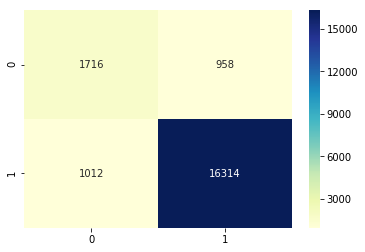

In [245]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [246]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 76%


In [247]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  90.14999999999999


### ROC

In [77]:
from sklearn.calibration import CalibratedClassifierCV

In [78]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=5)

In [79]:
calibrated.fit(standard_train_bow, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

In [80]:
y_pred_proba = calibrated.predict_proba(standard_test_bow)[:,1]

In [81]:
y_pred_proba.shape

(20000,)

In [82]:
from sklearn.metrics import roc_curve,roc_auc_score

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

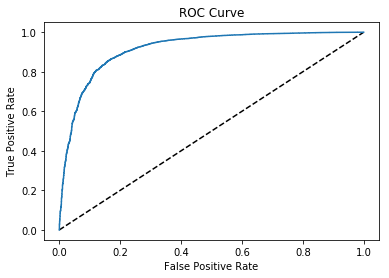

In [84]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### feature importance for count vectorizer

In [68]:
countvect = CountVectorizer(stop_words='english', min_df=5,max_features=2000)

In [69]:
positivebow = countvect.fit(positivereviews.CleanedText)

In [70]:
pos_xtrain = positivebow.transform(positivereviews.CleanedText)

In [71]:
from sklearn.svm import OneClassSVM

In [72]:
clf = OneClassSVM(kernel='linear')

### Positive reviews

In [78]:
pos_xtrain.shape

(307063, 2000)

In [102]:
feature_xtrain = pos_xtrain[0:100000,:]

In [103]:
feature_xtrain.shape

(100000, 2000)

In [104]:
feature_y = pos_y[0:100000]
feature_y.shape

(100000,)

In [105]:
clf.fit(feature_xtrain, feature_y)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
      kernel='linear', max_iter=-1, nu=0.5, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [106]:
x =(clf.coef_[0])

In [107]:
xcoord = x.tocoo()

In [108]:
xc = xcoord.data

In [109]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(xc, feature_names))
    top = (coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1) in top:
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))

In [110]:
show_most_informative_features(countvect, clf)

	10594.7672	yard           
	10019.0376	volum          
	9149.9380	walnut         
	7906.3971	spoil          
	7849.7952	thai           
	7570.2384	wise           
	7110.2844	trader         
	6593.7557	tassimo        
	5725.0867	weigh          
	5651.0000	irrit          
	5360.3667	xylitol        
	5256.0501	subtl          
	5012.1249	vile           
	4891.1270	veget          
	4584.5259	upset          
	4306.7583	throw          
	4198.0978	stand          
	4152.8369	whatsoev       
	3942.4169	tin            
	3614.2571	snack          


### Negative words

In [80]:
neg_y = negativereviews.Score

In [82]:
feature_y = neg_y[0:50000]
feature_y.shape

(50000,)

In [95]:
clf.coef_[0]

<1x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 1998 stored elements in Compressed Sparse Row format>

In [73]:
negativebow = countvect.fit(negativereviews.CleanedText)

In [74]:
neg_x_train = negativebow.transform(negativereviews.CleanedText)

In [77]:
feature_x_train = neg_x_train[0:50000,:]

In [78]:
feature_x_train.shape

(50000, 2000)

In [84]:
clf.fit(feature_x_train, feature_y)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
      kernel='linear', max_iter=-1, nu=0.5, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [85]:
y = clf.coef_[0]

In [86]:
ycoord = y.tocoo()

In [88]:
yc = ycoord.data

In [91]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(yc, feature_names))
    top = (coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1) in top:
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))

In [92]:
show_most_informative_features(countvect,clf)

	5817.7483	pricey         
	5394.5494	yesterday      
	4914.1687	watermelon     
	3706.0108	yard           
	3603.6447	proper         
	3440.8151	wrap           
	3119.1080	suggest        
	3064.3165	sprout         
	2889.9268	word           
	2420.5264	toxic          
	2385.8597	prepar         
	2290.5701	tender         
	2225.5794	percent        
	2189.4293	zico           
	2100.5557	yogurt         
	2088.9897	treat          
	2080.0000	suffer         
	2056.0000	work           
	2046.0000	vendor         
	2035.4904	recommend      


### L2 REGULARIZER

### LINEAR SVM L2

In [166]:
clf = SGDClassifier(loss='hinge', penalty='l2',random_state=42,)

In [167]:
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

In [168]:
model = GridSearchCV(estimator=clf, param_grid=params, scoring='f1', n_jobs=2)

In [169]:
model.fit(standard_train_bow, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [170]:
model.best_estimator_

SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [150]:
model.best_score_

0.9586839318748595

### applying our learnings

In [68]:
clf = SGDClassifier(alpha=0.1, penalty='l2', n_jobs=2, random_state=42)

In [69]:
clf.fit(standard_train_bow, y_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [70]:
y_pred = clf.predict(standard_test_bow)

In [71]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  91.565


In [72]:
cmat = confusion_matrix(y_test, y_pred)

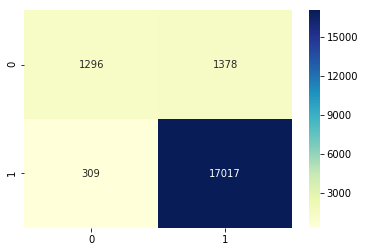

In [74]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [75]:
from collections import Counter
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [76]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 80%


In [77]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  91.565


In [78]:
print('precision score for testing set is ', precision_score(y_test, y_pred, average='micro')*100)

precision score for testing set is  91.565


### ROC

In [79]:
from sklearn.calibration import CalibratedClassifierCV

In [80]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=5)

In [81]:
calibrated.fit(standard_train_bow, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

In [82]:
y_pred_proba = calibrated.predict_proba(standard_test_bow)[:,1]

In [83]:
y_pred_proba.shape

(20000,)

In [84]:
from sklearn.metrics import roc_curve,roc_auc_score

In [85]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

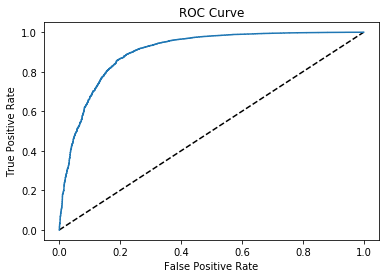

In [86]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [87]:
print('the roc_auc score for testing set is', (roc_auc_score(y_test, y_pred_proba)*100))

the roc_auc score for testing set is 90.10900323947538


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [63]:
clf = SGDClassifier(loss='hinge', penalty='l1',random_state=42, max_iter=100)

In [64]:
params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

In [65]:
model = GridSearchCV(cv=10,estimator=clf, param_grid=params, scoring='f1', n_jobs=2)

In [66]:
model.fit(standard_tfidf_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [67]:
model.best_estimator_

SGDClassifier(alpha=1, average=False, class_weight=None, early_stopping=False,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [68]:
model.best_score_

0.9394327720581973

### applying our learnings

In [69]:
clf = SGDClassifier(alpha=1, penalty='l1', n_jobs=2, random_state=42, max_iter=100)

In [70]:
clf.fit(standard_tfidf_train, y_train)

SGDClassifier(alpha=1, average=False, class_weight=None, early_stopping=False,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_iter_no_change=5, n_jobs=2, penalty='l1', power_t=0.5,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [71]:
y_pred = clf.predict(standard_tfidf_test)

In [72]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  86.63


In [73]:
cmat = confusion_matrix(y_test, y_pred)

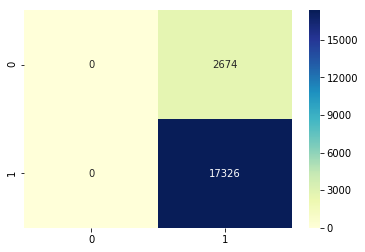

In [74]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [75]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 86%


In [76]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  86.63


### ROC

In [79]:
from sklearn.calibration import CalibratedClassifierCV

In [80]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=10)

In [81]:
calibrated.fit(standard_tfidf_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1, average=False, class_weight=None, early_stopping=False,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_iter_no_change=5, n_jobs=2, penalty='l1', power_t=0.5,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [82]:
y_pred_proba = calibrated.predict_proba(standard_tfidf_test)[:,1]

In [83]:
y_pred_proba.shape

(20000,)

In [84]:
from sklearn.metrics import roc_curve,roc_auc_score

In [85]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

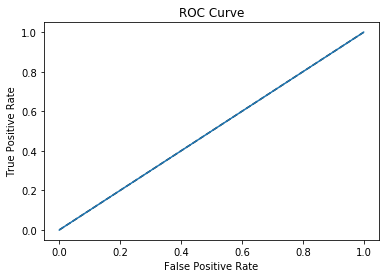

In [86]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

#### THE ABOVE RESULTS ARE EXPECTED AS OUR CLASSIFIER IS UNDERFITTING BADLY

#### LETS CHANGE WEIGHTS

In [77]:
weights={0:4, 1:0.5}

In [78]:
clf = SGDClassifier(loss='hinge', penalty='l1',random_state=42)

In [79]:
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

In [80]:
model = GridSearchCV(estimator=clf, param_grid=params, scoring='f1', n_jobs=2)

In [81]:
model.fit(standard_tfidf_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [82]:
model.best_estimator_

SGDClassifier(alpha=1, average=False, class_weight=None, early_stopping=False,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [83]:
model.best_score_

0.9394327731795226

### applying our learnings

In [84]:
clf = SGDClassifier(alpha=1, penalty='l1', n_jobs=2, random_state=42, class_weight=weights)

In [85]:
clf.fit(standard_tfidf_train, y_train)

SGDClassifier(alpha=1, average=False, class_weight={0: 4, 1: 0.5},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [86]:
y_pred = clf.predict(standard_tfidf_test)

In [87]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  86.615


In [88]:
cmat = confusion_matrix(y_test, y_pred)

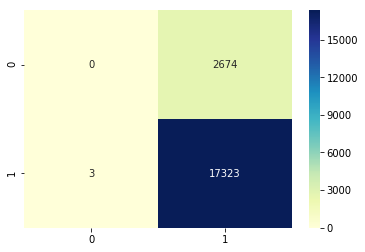

In [89]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [277]:
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [278]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 86%


In [279]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  86.63


### ROC

In [280]:
from sklearn.calibration import CalibratedClassifierCV

In [281]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=10)

In [282]:
calibrated.fit(standard_tfidf_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=100, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [283]:
y_pred_proba = calibrated.predict_proba(standard_tfidf_test)[:,1]

In [284]:
y_pred_proba.shape

(20000,)

In [285]:
from sklearn.metrics import roc_curve,roc_auc_score

In [286]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

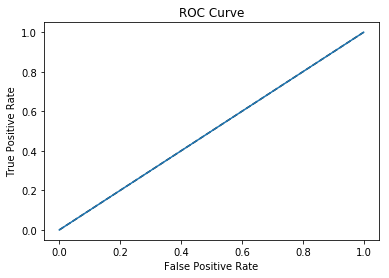

In [287]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### TRYING OVERSAMPLING AND UNDERSAMPLING

In [91]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [92]:
smote = SMOTE(n_jobs=2, random_state=10, ratio=1.0,)

In [93]:
x_sampled,y_sampled = smote.fit_resample(standard_tfidf_train, y_train)

In [94]:
resampled_x = x_sampled[40000:80000, :]

In [95]:
resampled_x.shape

(40000, 2000)

In [96]:
resampled_y = y_sampled[40000:80000]

In [97]:
resampled_y.shape

(40000,)

In [98]:
from collections import Counter
Counter(resampled_y)

Counter({1: 17554, 0: 22446})

### LETS GRIDSEARCH IN SMOTED DATAPOINTS

In [99]:
clf = SGDClassifier(loss='hinge', penalty='l1',random_state=42,)

In [100]:
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

In [101]:
model = GridSearchCV(estimator=clf, param_grid=params, scoring='f1', n_jobs=2)

In [102]:
model.fit(resampled_x, resampled_y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [103]:
model.best_estimator_

SGDClassifier(alpha=10, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [104]:
model.best_score_

0.40664815992493747

In [105]:
clf=SGDClassifier(penalty='l1',random_state=42,n_jobs=2, alpha=10)

In [106]:
clf.fit(resampled_x, resampled_y)

SGDClassifier(alpha=10, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [107]:
y_pred = clf.predict(standard_tfidf_test)

In [108]:
print('precision on testing data is ', precision_score(y_test, y_pred)*100)

precision on testing data is  86.63


In [109]:
print('recall score on testing data is ', recall_score(y_test, y_pred)*100)

recall score on testing data is  100.0


In [110]:
cmat = confusion_matrix(y_test, y_pred)

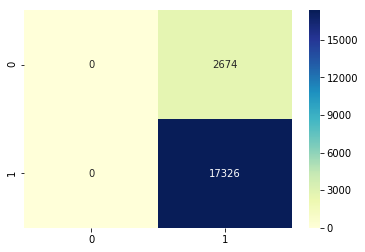

In [111]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [114]:
from sklearn.calibration import CalibratedClassifierCV

In [115]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=10)

In [116]:
calibrated.fit(standard_tfidf_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [117]:
y_pred_proba = calibrated.predict_proba(standard_tfidf_test)[:,1]

In [118]:
y_pred_proba.shape

(20000,)

In [119]:
from sklearn.metrics import roc_curve,roc_auc_score

In [120]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

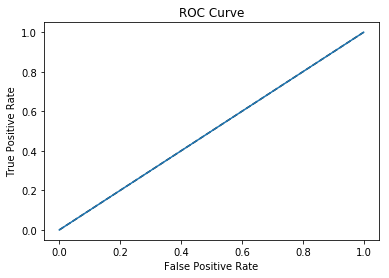

In [121]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [122]:
cmat = confusion_matrix(y_test, y_pred)

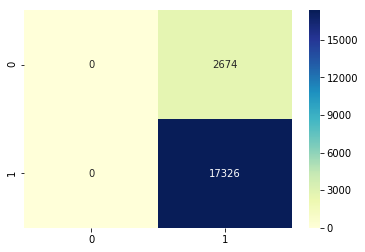

In [123]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### nearmiss

In [124]:
nm = NearMiss(ratio=1, n_jobs=2, random_state=42)

In [125]:
x_sampled,y_sampled = nm.fit_resample(standard_tfidf_train, y_train)

In [127]:
x_sampled.shape

(13706, 2000)

In [128]:
y_sampled.shape

(13706,)

In [150]:
resampled_x = x_sampled[0:13000]

In [151]:
resampled_x.shape

(13000, 2000)

In [153]:
resampled_y = y_sampled[0:13000]

In [156]:
resampled_y.shape

(13000,)

### LETS GRIDSEARCH IN NEARMISS DATAPOINTS

In [157]:
clf = SGDClassifier(loss='hinge', penalty='l1',random_state=42,)

In [158]:
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

In [159]:
model = GridSearchCV(estimator=clf, param_grid=params, scoring='f1', n_jobs=2)

In [160]:
model.fit(resampled_x, resampled_y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [161]:
model.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [162]:
model.best_score_

0.6524031484619718

In [163]:
clf=SGDClassifier(alpha=0.0001,penalty='l1',random_state=42,n_jobs=2,)

In [164]:
clf.fit(resampled_x, resampled_y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [165]:
y_pred = clf.predict(standard_tfidf_test)

In [166]:
print('precision on testing data is ', precision_score(y_test, y_pred)*100)

precision on testing data is  87.1169807381114


In [167]:
print('recall score on testing data is ', recall_score(y_test, y_pred)*100)

recall score on testing data is  96.32344453422603


In [168]:
cmat = confusion_matrix(y_test, y_pred)

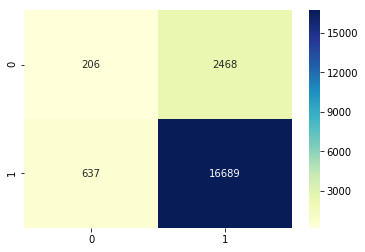

In [169]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

# Nearmiss worked!!!

In [170]:
from sklearn.calibration import CalibratedClassifierCV

In [171]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=10)

In [172]:
calibrated.fit(standard_tfidf_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [173]:
y_pred_proba = calibrated.predict_proba(standard_tfidf_test)[:,1]

In [174]:
y_pred_proba.shape

(20000,)

In [175]:
from sklearn.metrics import roc_curve,roc_auc_score

In [176]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

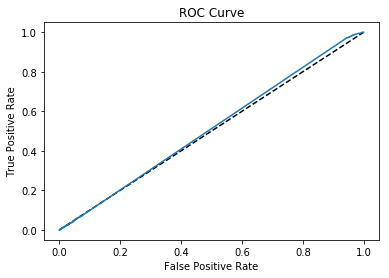

In [177]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [178]:
cmat = confusion_matrix(y_test, y_pred)

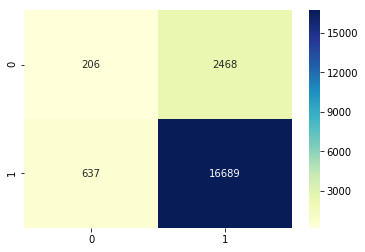

In [179]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### L2 tfidf

In [68]:
clf = SGDClassifier(loss='hinge', penalty='l2',random_state=42, max_iter=100)

In [69]:
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000]}

In [85]:
model = GridSearchCV(cv=10,estimator=clf, param_grid=params, scoring='f1', n_jobs=2, verbose=1)

In [86]:
model.fit(standard_tfidf_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.6s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:   13.4s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=1, average=False, class_weight=None, early_stopping=False,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_iter_no_change=5, n_jobs=2, penalty='l2', power_t=0.5,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [87]:
model.best_estimator_

SGDClassifier(alpha=1000, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [88]:
model.best_params_

{'alpha': 1000}

In [89]:
model.best_score_

0.9394327720581973

### applying our learnings

In [103]:
clf = SGDClassifier(alpha=10, penalty='l2', n_jobs=2, random_state=42, max_iter=100)

In [104]:
clf.fit(standard_tfidf_train, y_train)

SGDClassifier(alpha=10, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [105]:
y_pred = clf.predict(standard_tfidf_test)

In [106]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  86.605


In [107]:
cmat = confusion_matrix(y_test, y_pred)

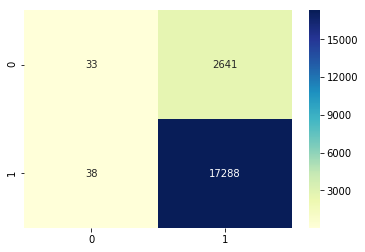

In [108]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [109]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 86%


In [110]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  86.605


### ROC

In [111]:
from sklearn.calibration import CalibratedClassifierCV

In [112]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=10)

In [113]:
calibrated.fit(standard_tfidf_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [114]:
y_pred_proba = calibrated.predict_proba(standard_tfidf_test)[:,1]

In [115]:
y_pred_proba.shape

(20000,)

In [116]:
from sklearn.metrics import roc_curve,roc_auc_score

In [117]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

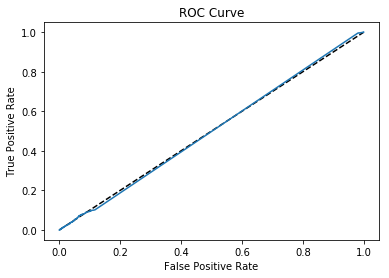

In [118]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [63]:
clf = SGDClassifier(loss='hinge', penalty='l1',random_state=42, max_iter=100)

In [64]:
params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

In [65]:
model = GridSearchCV(cv=10,estimator=clf, param_grid=params, scoring='f1', n_jobs=2)

In [66]:
model.fit(standard_avgw2v_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [69]:
model.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [70]:
model.best_score_

0.9487344816038727

### applying our learnings

In [71]:
clf = SGDClassifier(alpha=0.0001, penalty='l1', n_jobs=2, random_state=42, max_iter=100)

In [72]:
clf.fit(standard_avgw2v_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [76]:
y_pred = clf.predict(standard_avgw2v_test)

In [77]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  89.445


In [78]:
cmat = confusion_matrix(y_test, y_pred)

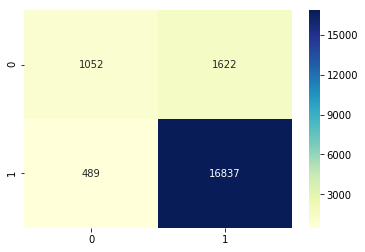

In [79]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [80]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 80%


In [81]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  89.445


### ROC

In [82]:
from sklearn.calibration import CalibratedClassifierCV

In [83]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=10)

In [84]:
calibrated.fit(standard_avgw2v_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [85]:
y_pred_proba = calibrated.predict_proba(standard_avgw2v_test)[:,1]

In [86]:
y_pred_proba.shape

(20000,)

In [87]:
from sklearn.metrics import roc_curve,roc_auc_score

In [88]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

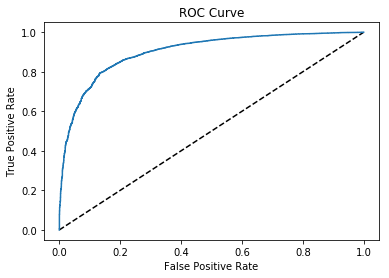

In [89]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

## AVGW2V L2

In [90]:
clf = SGDClassifier(loss='hinge', penalty='l2',random_state=42, max_iter=100)

In [91]:
params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

In [92]:
model = GridSearchCV(cv=10,estimator=clf, param_grid=params, scoring='f1', n_jobs=2)

In [93]:
model.fit(standard_avgw2v_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [96]:
model.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [97]:
model.best_score_

0.9493769285317143

### applying our learnings

In [98]:
clf = SGDClassifier(alpha=0.001, penalty='l2', n_jobs=2, random_state=42, max_iter=100)

In [99]:
clf.fit(standard_avgw2v_train, y_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [100]:
y_pred = clf.predict(standard_avgw2v_test)

In [101]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  89.34


In [102]:
cmat = confusion_matrix(y_test, y_pred)

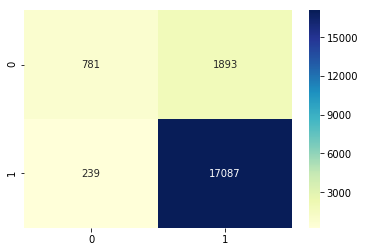

In [103]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [104]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 82%


In [105]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  89.34


### ROC

In [106]:
from sklearn.calibration import CalibratedClassifierCV

In [107]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=10)

In [108]:
calibrated.fit(standard_avgw2v_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [109]:
y_pred_proba = calibrated.predict_proba(standard_avgw2v_test)[:,1]

In [110]:
y_pred_proba.shape

(20000,)

In [111]:
from sklearn.metrics import roc_curve,roc_auc_score

In [112]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

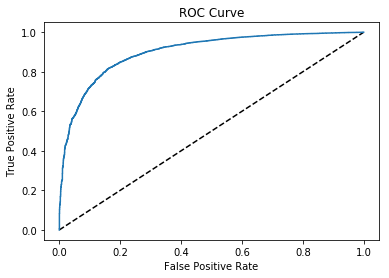

In [113]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [114]:
clf = SGDClassifier(loss='hinge', penalty='l1',random_state=42, max_iter=100)

In [115]:
params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

In [116]:
model = GridSearchCV(cv=10,estimator=clf, param_grid=params, scoring='f1', n_jobs=2)

In [117]:
model.fit(standard_tfidfw2v_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [120]:
model.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [121]:
model.best_score_

0.9452024240437686

### applying our learnings

In [122]:
clf = SGDClassifier(alpha=0.0001, penalty='l1', n_jobs=2, random_state=42, max_iter=100)

In [123]:
clf.fit(standard_tfidfw2v_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [124]:
y_pred = clf.predict(standard_tfidfw2v_test)

In [125]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  87.95500000000001


In [126]:
cmat = confusion_matrix(y_test, y_pred)

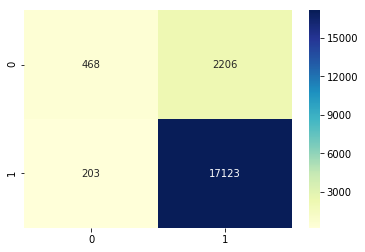

In [127]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [128]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 83%


In [129]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  87.95500000000001


### ROC

In [130]:
from sklearn.calibration import CalibratedClassifierCV

In [131]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=10)

In [132]:
calibrated.fit(standard_tfidfw2v_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [133]:
y_pred_proba = calibrated.predict_proba(standard_tfidfw2v_test)[:,1]

In [134]:
y_pred_proba.shape

(20000,)

In [135]:
from sklearn.metrics import roc_curve,roc_auc_score

In [136]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

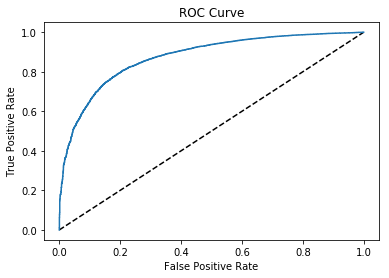

In [137]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# TFIDFW2V L2

In [138]:
clf = SGDClassifier(loss='hinge', penalty='l2',random_state=42, max_iter=100)

In [139]:
params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

In [140]:
model = GridSearchCV(cv=10,estimator=clf, param_grid=params, scoring='f1', n_jobs=2)

In [141]:
model.fit(standard_tfidfw2v_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [142]:
model.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [143]:
model.best_score_

0.9453469023875853

### applying our learnings

In [145]:
clf = SGDClassifier(alpha=0.0001, penalty='l2', n_jobs=2, random_state=42, max_iter=100)

In [146]:
clf.fit(standard_tfidfw2v_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [147]:
y_pred = clf.predict(standard_tfidfw2v_test)

In [148]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  88.115


In [149]:
cmat = confusion_matrix(y_test, y_pred)

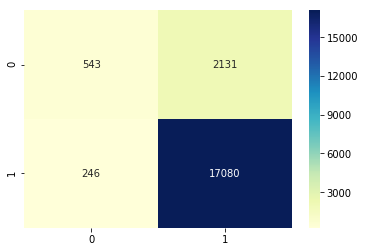

In [150]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [151]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 83%


In [152]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  88.115


### ROC

In [153]:
from sklearn.calibration import CalibratedClassifierCV

In [154]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=10)

In [155]:
calibrated.fit(standard_tfidfw2v_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=2, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [156]:
y_pred_proba = calibrated.predict_proba(standard_tfidfw2v_test)[:,1]

In [157]:
y_pred_proba.shape

(20000,)

In [158]:
from sklearn.metrics import roc_curve,roc_auc_score

In [159]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

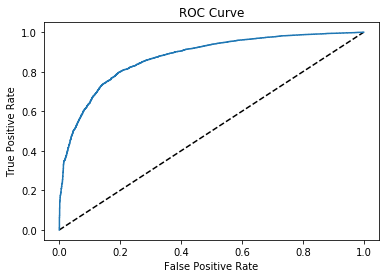

In [160]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

## [5.2] RBF SVM

## [5.2.0] Imports

In [63]:
con = sqlite3.connect('final.sqlite')

In [64]:
df = pd.read_sql_query('''
SELECT * FROM Reviews
WHERE SCORE !=3
''', con)

In [65]:
sorted_df = df.sort_values('Time', axis=0)

In [66]:
x_train = sorted_df.iloc[0:30000,:]

In [67]:
x_train.shape

(30000, 12)

In [68]:
x_train = x_train['CleanedText']

In [69]:
x_train.shape

(30000,)

In [70]:
y_train = y_train[0:30000]

In [71]:
y_train.shape

(30000,)

In [72]:
x_test = sorted_df.iloc[30000:50000,:]

In [73]:
x_test.shape

(20000, 12)

In [74]:
x_test = x_test.CleanedText

### Countvectorizer

In [78]:
countvect = CountVectorizer(min_df=10, max_features=500, dtype='float')

In [79]:
cv = countvect.fit(x_train)

In [80]:
std_x_train = cv.transform(x_train)

In [81]:
std_x_test = cv.transform(x_test)

In [82]:
std_x_train.shape

(30000, 500)

In [83]:
std_x_test.shape

(20000, 500)

In [84]:
std_x_train.shape

(30000, 500)

### Standardization

In [85]:
std = StandardScaler(with_mean=False)

In [86]:
std.fit(std_x_train)

StandardScaler(copy=True, with_mean=False, with_std=True)

In [87]:
std_x_train = std.transform(std_x_train)

In [88]:
std_x_test = std.transform(std_x_test)

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [89]:
clf = SVC(C=1.0, gamma=0.001,kernel='rbf')

In [90]:
params=[{'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]}, {'gamma':[0.0001,0.001,0.01,0.1]}]

In [91]:
model = GridSearchCV(estimator=clf,param_grid=params,scoring='f1', n_jobs=2)

In [92]:
model.fit(std_x_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}, {'gamma': [0.0001, 0.001, 0.01, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [94]:
model.best_estimator_

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [95]:
model.best_score_

0.9520337570240469

In [96]:
new_standard_bow_train = standard_train_bow[0:30000,:]

In [98]:
y_train.shape

(30000,)

### applying our learnings

In [99]:
clf = SVC(C=10, gamma=0.001,kernel='rbf')

In [100]:
clf.fit(new_standard_bow_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [101]:
y_pred = clf.predict(standard_test_bow)

In [102]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  89.215


In [103]:
cmat = confusion_matrix(y_test, y_pred)

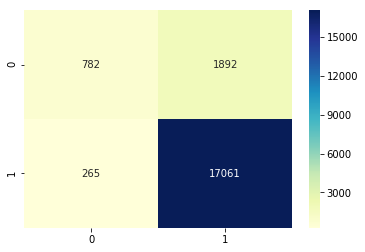

In [104]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [105]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  89.215


### ROC

In [106]:
from sklearn.calibration import CalibratedClassifierCV

In [107]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=5)

In [108]:
calibrated.fit(new_standard_bow_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
            cv=5, method='sigmoid')

In [109]:
y_pred_proba = calibrated.predict_proba(standard_test_bow)[:,1]

In [110]:
y_pred_proba.shape

(20000,)

In [111]:
from sklearn.metrics import roc_curve,roc_auc_score

In [112]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

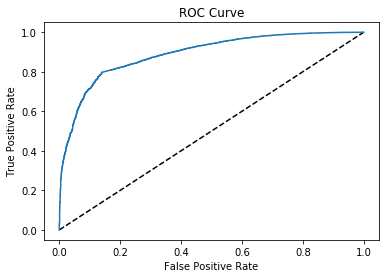

In [113]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [76]:
tfidf = TfidfVectorizer(min_df=10, max_features=500, dtype='float')

In [77]:
vectorizer = tfidf.fit(x_train)

In [78]:
std_x_train = vectorizer.transform(x_train)

In [79]:
std_x_test = vectorizer.transform(x_test)

In [80]:
std_x_train.shape

(30000, 500)

In [81]:
std_x_test.shape

(20000, 500)

In [82]:
std_x_train.shape

(30000, 500)

### Standardization

In [83]:
std = StandardScaler(with_mean=False)

In [84]:
std.fit(std_x_train)

StandardScaler(copy=True, with_mean=False, with_std=True)

In [85]:
std_x_train = std.transform(std_x_train)

In [86]:
std_x_test = std.transform(std_x_test)

## Kernel svm

In [87]:
clf = SVC(C=1.0, gamma=0.001,kernel='rbf')

In [88]:
params=[{'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]}, {'gamma':[0.0001,0.001,0.01,0.1]}]

In [89]:
model = GridSearchCV(estimator=clf,param_grid=params,scoring='f1', n_jobs=2)

In [90]:
model.fit(std_x_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}, {'gamma': [0.0001, 0.001, 0.01, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [91]:
model.best_estimator_

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [92]:
model.best_score_

0.952689703847523

In [93]:
new_standard_bow_train = standard_tfidf_train[0:30000,:]

In [94]:
y_train.shape

(30000,)

### applying our learnings

In [95]:
clf = SVC(C=10, gamma=0.001,kernel='rbf')

In [96]:
clf.fit(new_standard_bow_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
y_pred = clf.predict(standard_tfidf_test)

In [98]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  86.31


In [99]:
cmat = confusion_matrix(y_test, y_pred)

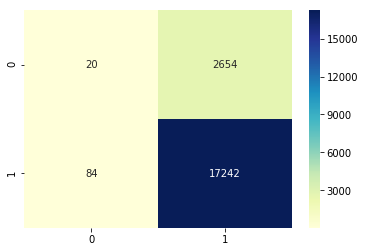

In [100]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [101]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  86.31


### ROC

In [102]:
from sklearn.calibration import CalibratedClassifierCV

In [103]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=5)

In [104]:
calibrated.fit(new_standard_bow_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
            cv=5, method='sigmoid')

In [105]:
y_pred_proba = calibrated.predict_proba(standard_tfidf_test)[:,1]

In [106]:
y_pred_proba.shape

(20000,)

In [107]:
from sklearn.metrics import roc_curve,roc_auc_score

In [108]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

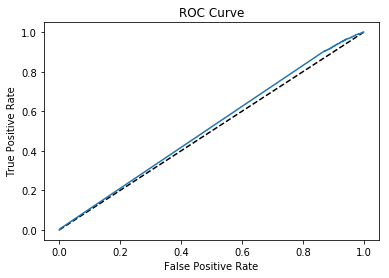

In [109]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [115]:
standard_avgw2v_train.shape

(60000, 100)

In [118]:
new_standard_avgw2v_train = standard_avgw2v_train[0:30000,:]

In [117]:
y_train.shape

(30000,)

## Kernel svm

In [119]:
clf = SVC(C=1.0, gamma=0.001,kernel='rbf')

In [120]:
params=[{'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]}, {'gamma':[0.0001,0.001,0.01,0.1]}]

In [121]:
model = GridSearchCV(estimator=clf,param_grid=params,scoring='f1', n_jobs=2)

In [122]:
model.fit(new_standard_avgw2v_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}, {'gamma': [0.0001, 0.001, 0.01, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [123]:
model.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [124]:
model.best_score_

0.9559294567737425

In [96]:
new_standard_bow_train = standard_train_bow[0:30000,:]

In [98]:
y_train.shape

(30000,)

### applying our learnings

In [125]:
clf = SVC(C=100, gamma=0.001,kernel='rbf')

In [126]:
clf.fit(new_standard_avgw2v_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [127]:
y_pred = clf.predict(standard_avgw2v_test)

In [128]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  90.145


In [129]:
cmat = confusion_matrix(y_test, y_pred)

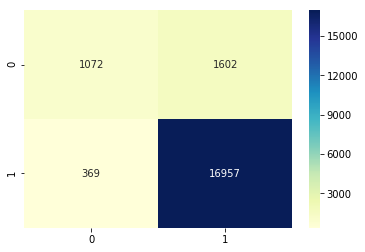

In [130]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [131]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  90.145


### ROC

In [132]:
from sklearn.calibration import CalibratedClassifierCV

In [133]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=5)

In [134]:
calibrated.fit(new_standard_avgw2v_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
            cv=5, method='sigmoid')

In [135]:
y_pred_proba = calibrated.predict_proba(standard_avgw2v_test)[:,1]

In [136]:
y_pred_proba.shape

(20000,)

In [137]:
from sklearn.metrics import roc_curve,roc_auc_score

In [138]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

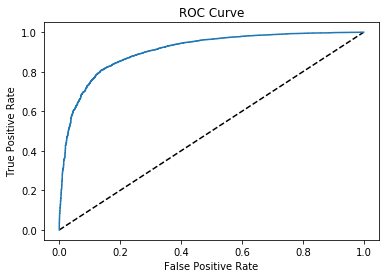

In [139]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

### vectorizer

In [140]:
standard_tfidfw2v_train.shape

(60000, 100)

In [141]:
new_standard_tfidfw2v_train = standard_tfidfw2v_train[0:30000,:]

In [144]:
new_standard_tfidfw2v_train.shape

(30000, 100)

In [145]:
y_train.shape

(30000,)

## Kernel svm

In [146]:
clf = SVC(C=1.0, gamma=0.001,kernel='rbf')

In [147]:
params=[{'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]}, {'gamma':[0.0001,0.001,0.01,0.1]}]

In [148]:
model = GridSearchCV(estimator=clf,param_grid=params,scoring='f1', n_jobs=2)

In [149]:
model.fit(new_standard_tfidfw2v_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}, {'gamma': [0.0001, 0.001, 0.01, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [150]:
model.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [151]:
model.best_score_

0.9531515294399946

### applying our learnings

In [152]:
clf = SVC(C=100, gamma=0.001,kernel='rbf')

In [153]:
clf.fit(new_standard_tfidfw2v_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [154]:
y_pred = clf.predict(standard_tfidfw2v_test)

In [155]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  89.425


In [156]:
cmat = confusion_matrix(y_test, y_pred)

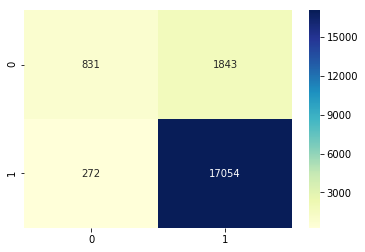

In [157]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [158]:
print('recall score for testing set is ', recall_score(y_test, y_pred, average='micro')*100)

recall score for testing set is  89.425


### ROC

In [159]:
from sklearn.calibration import CalibratedClassifierCV

In [160]:
calibrated = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=5)

In [161]:
calibrated.fit(new_standard_tfidfw2v_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
            cv=5, method='sigmoid')

In [162]:
y_pred_proba = calibrated.predict_proba(standard_tfidfw2v_test)[:,1]

In [163]:
y_pred_proba.shape

(20000,)

In [164]:
from sklearn.metrics import roc_curve,roc_auc_score

In [165]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5,1,'ROC Curve')

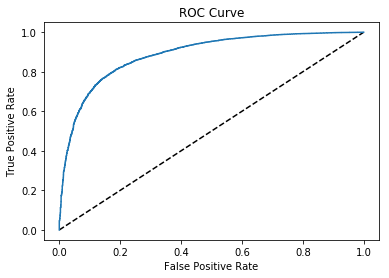

In [166]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [3]:
# Please write all the code with proper documentation

# [6] Conclusions

In [1]:
from prettytable import PrettyTable

In [10]:
x = PrettyTable()

In [11]:
x.field_names = ['type','regularizer','vectorizer','train f1 score','test f1 score']

In [13]:
x.add_row(["LinearSVM", 'l1', 'bow', 94, 90])
x.add_row(["LinearSVM", 'l1', 'tfidf', 93, 86])
x.add_row(["LinearSVM", 'l1', 'avgw2v', 95, 89])
x.add_row(["LinearSVM", 'l1', 'tfidfw2v', 94, 88])

In [14]:
x.add_row(["LinearSVM", 'l2', 'bow', 95, 91])
x.add_row(["LinearSVM", 'l2', 'tfidf', 93, 86])
x.add_row(["LinearSVM", 'l2', 'avgw2v', 95, 89])
x.add_row(["LinearSVM", 'l2', 'tfidfw2v', 94, 88])

In [15]:
x.add_row(["RBF Kernel", '-', 'bow', 95, 89])
x.add_row(["RBF Kernel", '-', 'tfidf', 95, 86])
x.add_row(["RBF Kernel", '-', 'avgw2v', 95, 90])
x.add_row(["RBF Kernel", '-', 'tfidfw2v', 95, 89])

In [16]:
print(x)

+------------+-------------+------------+----------------+---------------+
|    type    | regularizer | vectorizer | train f1 score | test f1 score |
+------------+-------------+------------+----------------+---------------+
| LinearSVM  |      l1     |    bow     |       94       |       90      |
| LinearSVM  |      l1     |   tfidf    |       93       |       86      |
| LinearSVM  |      l1     |   avgw2v   |       95       |       89      |
| LinearSVM  |      l1     |  tfidfw2v  |       94       |       88      |
| LinearSVM  |      l2     |    bow     |       95       |       91      |
| LinearSVM  |      l2     |   tfidf    |       93       |       86      |
| LinearSVM  |      l2     |   avgw2v   |       95       |       89      |
| LinearSVM  |      l2     |  tfidfw2v  |       94       |       88      |
| RBF Kernel |      -      |    bow     |       95       |       89      |
| RBF Kernel |      -      |   tfidf    |       95       |       86      |
| RBF Kernel |      -    